### Time Analysis of the Website's Attractiveness to the Different Classes of Raters

In [640]:
import pandas as pd
import numpy as np

import ingestion as ing

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the data

In [641]:
# read the users
users_ddf = ing.read_parquet(
    path=ing.build_path(folderind="ba", filename="users_with_scores", ext=".parquet", basepath=ing.REFINED_PATH),
    keepcols=None,
    assume_missing=False,
    mode="lazy")

In [642]:
# compute dataframe
users_df = users_ddf.compute()
users_df.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location',
       'country', 'cfm_score', 'exp_score', 'xpl_score', 'adv_score', 'is_cfm',
       'is_exp', 'is_xpl', 'is_adv'],
      dtype='object')

In [643]:
# added a "classified" column to the dataframe to easily find classified/unclassified users
class_indicators = ["is_cfm", "is_exp", "is_xpl", "is_adv"]
users_df = users_df.assign(classified=(users_df[class_indicators].sum(axis=1) != 0).astype(int))
users_df.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location',
       'country', 'cfm_score', 'exp_score', 'xpl_score', 'adv_score', 'is_cfm',
       'is_exp', 'is_xpl', 'is_adv', 'classified'],
      dtype='object')

In [644]:
# sanity check, should be TRUE
len(users_df.query("classified == 0")) + len(users_df.query("+".join(class_indicators) + " > 0")) == len(users_ddf)

True

### Time Analysis

Users joining the website grouped by year

In [656]:
# all users accounted for
by_year = users_df.groupby(by=users_df.joined.dt.year)

In [657]:
# conformists
cfms = users_df.query("is_cfm == 1")
cfms_by_year = cfms.groupby(by=cfms.joined.dt.year)
n_cfms_by_year = pd.DataFrame(cfms_by_year.size(), columns=["size"])

In [658]:
# expert-like users
exps = users_df.query("is_exp == 1")
exps_by_year = exps.groupby(by=exps.joined.dt.year)
n_exps_by_year = pd.DataFrame(exps_by_year.size(), columns=["size"])

In [659]:
# adventurers
advs = users_df.query("is_adv == 1")
advs_by_year = advs.groupby(by=advs.joined.dt.year)
n_advs_by_year = pd.DataFrame(advs_by_year.size(), columns=["size"])

In [660]:
# explorers
xpls = users_df.query("is_xpl == 1")
xpls_by_year = xpls.groupby(by=xpls.joined.dt.year)
n_xpls_by_year = pd.DataFrame(xpls_by_year.size(), columns=["size"])

In [661]:
# all classified users
classified_users = users_df.query("classified == 1")
classified_by_year = classified_users.groupby(by=classified_users.joined.dt.year)
n_classified_by_year = pd.DataFrame(classified_by_year.size(), columns=["size"])

In [662]:
n_by_year = {
    "cfm": n_cfms_by_year,
    "xpl": n_xpls_by_year,
    "exp": n_exps_by_year,
    "adv": n_advs_by_year
    }

In [663]:
CMAP = {
    "cfm": "blue",
    "xpl": "magenta",
    "exp": "green",
    "adv": "red", 
    "classified": "grey"
}

In [688]:
all_years = users_df.joined.dt.year.sort_values().unique()
all_years

array([1996, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

Evolution of Signed-Ups over Time

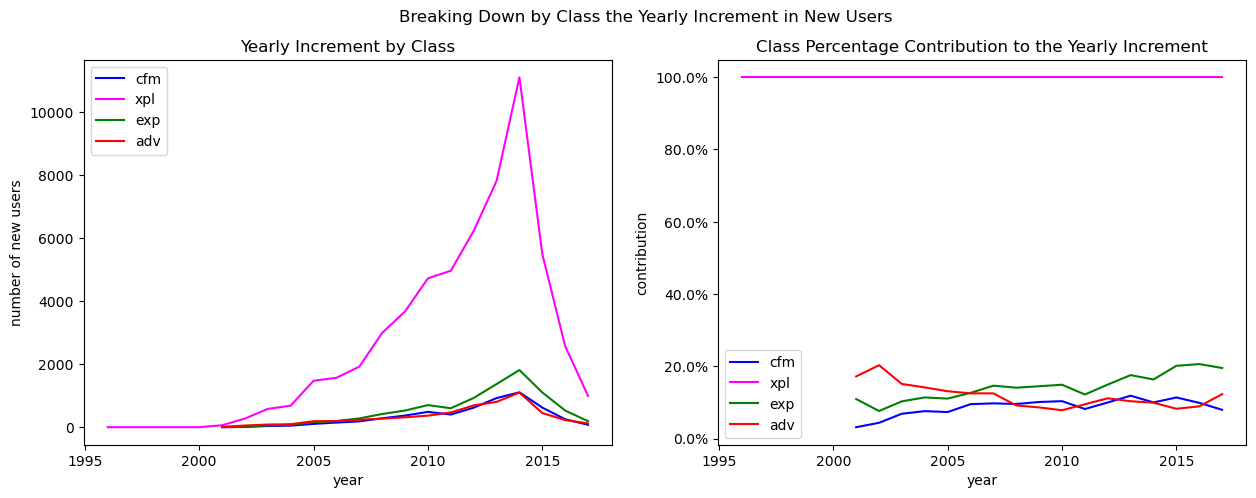

In [714]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Breaking Down by Class the Yearly Increment in New Users")

for class_, df in n_by_year.items():
    sns.lineplot(data=df, x=df.index, y="size", ax=ax1, label=class_, color=CMAP[class_])
ax1.set_title("Yearly Increment by Class")
ax1.set_xlabel("year")
ax1.set_ylabel("number of new users")
ax1.legend()


for class_, df in n_by_year.items():
    df = df.copy()
    df["percent"] = (df / n_classified_by_year).dropna()
    sns.lineplot(data=df, x=df.index, y="percent", ax=ax2, label=class_, color=CMAP[class_])
    
ax2.set_title("Class Percentage Contribution to the Yearly Increment")
ax2.set_xlabel("year")
ax2.set_ylabel("contribution")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
ax2.legend()

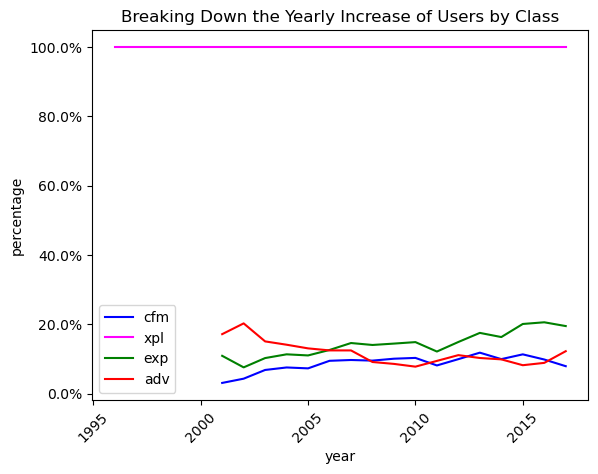

In [666]:
# plot the timely number of total classified users